# Requirements

## Install packages

In [1]:
import sys

!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install mlflow
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install pandas

## Imports

In [2]:
import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import mlflow
import numpy as np
import seaborn as sns
import pandas as pd

## Download dataset

In [3]:
mnist = sklearn.datasets.load_digits()

In [4]:
X = mnist.data
Y = mnist.target

X_train, X_test, y_train, y_test = train_test_split(X, Y)

# Experiment tracking

## Simple example

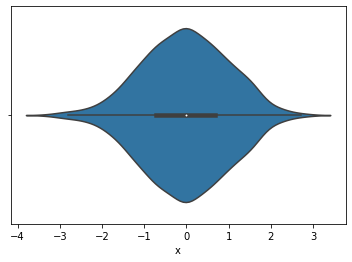

In [5]:
# Start a ML flow experiemnt
with mlflow.start_run():
    
    # Log parameters
    mlflow.log_param("Param1", 0)
    mlflow.log_param("Param2", 1)
    
    # Log metrics
    mlflow.log_metric("Metric1", 2)
    mlflow.log_metric("Metric2", 3)
    
    # Log tag
    mlflow.set_tag("user_name", "k.villatel")
    
    # Log artifacts
    sns_plot = sns.violinplot(x="x", data=pd.DataFrame(columns=["x"], data=np.random.randn(1000)))
    fig = sns_plot.get_figure() 
    fig.savefig("fig.png")
    mlflow.log_artifact("fig.png")

Experiment can now be accessed with `mlflow ui` command.

# Build models

In [6]:
def compute_accuracy(y_true, y_pred):
    acc = accuracy_score(y_true=y_true, y_pred=y_pred)
    mlflow.log_metric("Accuracy", acc)

In [7]:
def multinomial_log_reg_model(max_iter=100):
    with mlflow.start_run(nested=True):
        # Log params in ml flow
        mlflow.log_param("algo", "multinomial log reg")
        mlflow.log_param("max_iter", max_iter)

        # Build classifier
        classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=max_iter)

        # Fit
        classifier.fit(X=X_train, y=y_train.reshape((-1, 1)))

        # Evaluate
        y_pred = classifier.predict(X=X_test)

        compute_accuracy(y_true=y_test, y_pred=y_pred)

# Experiment tracking

In [8]:
mlflow.set_experiment(experiment_name="mnist")

In [9]:
with mlflow.start_run():
    for max_iter in [10, 100, 1000, 10000]:
        multinomial_log_reg_model(max_iter=max_iter)

/home/k.villatel/.conda/envs/technical_presentations/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/k.villatel/.conda/envs/technical_presentations/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/k.villatel/.conda/envs/technical_presentations/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/k.villatel/.conda/envs/technical_presentations/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to